# Vertically Disintegrated Platforms
### Code for replication of numerical results (Figure 2)
*Reference*: 
Aymanns, Christoph, Mathias Dewatripont, and Tarik Roukny. "Vertically Disintegrated Platforms." Available at SSRN 3507355 (2019).

In [1]:
import numpy as np
import math
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from scipy.stats import expon
from scipy.optimize import fsolve
from scipy.stats import gamma as gamma_dist
from scipy.special import gamma as gamma_fun
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import minimize

### Functions

In [9]:
def F_mu(x, params):
    temp1 = gamma_dist.cdf(x, params['shape'], loc=params['loc'], scale=params['scale'])
    return temp1

def f_mu(x, params):
    temp1 = gamma_dist.pdf(x, params['shape'], loc=params['loc'], scale=params['scale'])
    return temp1

def comp_demand(p, params):
    return 1 - F_mu(p, params)

def comp_supply(p, params):
    return 1 - np.exp(-params['lam'] * p)

def cost(d, params):
    lam = params['lam']
    c_star = -1. / lam * np.log(1 - d)
    c = - c_star * np.exp(-lam * c_star) + 1. / lam * (1 - np.exp(-lam * c_star))
    return c, c_star

def profit_vip(p, params_d, params_s):
    d = comp_demand(p, params_d)
    c, c_star = cost(d, params_s)
    prof = p * d - c - params_s['integration'](d)
    return prof

def profit_vdp(p, params_d, params_s):
    d = comp_demand(p, params_d)
    c, c_star = cost(d, params_s)
    prof = p * d - c_star * d
    return prof

def market_clear(p, t, params_d, params_s):
    d = comp_demand(p, params_d)
    s = comp_supply(p*(1-t), params_s)
    return d - s

def profit_vdp_t(t, params_d, params_s):
    p = fsolve(market_clear, 1, args=(t, params_d, params_s, ))
    d = comp_demand(p, params_d)
    prof = t * d * p
    return prof, p, d

def fun_vdp(x, params_d, params_s):
    prof, p, d = profit_vdp_t(x, params_d, params_s)
    return -prof

def fun_vip(x, params_d, params_s):
    prof = profit_vip(x, params_d, params_s)
    return -prof

def user_platform_preferences(slope, intercept, params_d, params_s, exponent=1):
    params_s['integration'] = lambda x : slope *x**exponent + intercept
    opt_vip = minimize(fun_vip, 30., (params_d, params_s, ))
    demand_vip = comp_demand(opt_vip['x'], params_d)[0]
    vip_profit = -opt_vip['fun']
    return vip_profit, demand_vip

### Computation

In [16]:
%%time
params_d = {
    'shape' : 3,
    'loc' : 20,
    'scale' : 1/0.1
}

params_s = {
    'lam' : 0.5,
    'integration' : None
}

opt_vdp = minimize(fun_vdp, 0.1, (params_d, params_s, ))
p_vdp = fsolve(market_clear, 1, args=(opt_vdp['x'], params_d, params_s, ))
demand_vdp = comp_demand(p_vdp, params_d)[0]
vdp_profit = -opt_vdp['fun']

# param value (alpha, beta)
slopes = np.linspace(0, 10.1, num=100)
intercepts = np.linspace(-5.1, 5.1, num=100)

vip_profit = np.zeros((slopes.shape[0], intercepts.shape[0]))
demand_vip = np.zeros((slopes.shape[0], intercepts.shape[0]))

for i, s in enumerate(slopes):
    for j, inter in enumerate(intercepts):
        vip_profit[i, j], demand_vip[i, j] = user_platform_preferences(s, inter, params_d, params_s, exponent=1)
        
d_profit = vip_profit - vdp_profit
d_demand = demand_vip - demand_vdp

CPU times: user 23.5 s, sys: 121 ms, total: 23.6 s
Wall time: 23.7 s


### Data treatment

In [17]:
d_demand_df = pd.DataFrame(d_demand, columns=np.around(intercepts, decimals=2), index=np.around(slopes, decimals=2))
d_profit_df = pd.DataFrame(d_profit, columns=np.around(intercepts, decimals=2), index=np.around(slopes, decimals=2))
vip_profit_df = pd.DataFrame(vip_profit, columns=np.around(intercepts, decimals=2), index=np.around(slopes, decimals=2))

In [18]:
combined = np.zeros(d_demand.shape)
for i in range(combined.shape[0]):
    for j in range(combined.shape[1]):
        if d_demand[i, j] > 0 and d_profit[i, j] > 0:
            flag = 1
        elif d_demand[i, j] < 0 and d_profit[i, j] > 0:
            flag = 2
        elif d_demand[i, j] > 0 and d_profit[i, j] < 0:
            flag = 3
        elif d_demand[i, j] < 0 and d_profit[i, j] < 0:
            flag = 4
            
        combined[i, j] = flag
combined_df = pd.DataFrame(combined, columns=np.around(intercepts, decimals=1), index=np.around(slopes, decimals=1))

### Visualisation

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


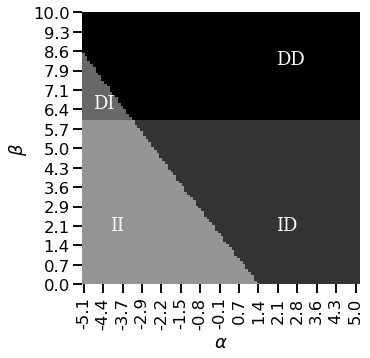

In [20]:
sns.set_context('talk')
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
sns.heatmap(combined_df, cbar=False, square=True, cmap='Greys', center=True, ax=ax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.invert_yaxis()
ax.text(10, 20, 'II',family='serif', color='white') # A: user and platform prefer VIP
ax.text(70, 20, 'ID', family='serif',color='white') # B: user prefers VIP, platform prefers VDP
ax.text(70, 80, 'DD', family='serif', color='white') # C : user prefers VDP, platform prefers VDP
ax.text(4, 64, 'DI', family='serif', color='white') # D: user prefers VDP, platform prefers VIP
# f.savefig('user_platform_preference_regions.pdf')
f.show()